In [1]:
import os
import copy
import json
import numpy as np
from PIL import Image
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

d:\Program Files\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


In [3]:
get_label = lambda x: x.name.split('.')[0]

class get_dataset(Dataset):
    def __init__(self, root, transform=None):
        self.images = list(Path(root).glob('*.jpg'))
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = get_label(img)
        label = 1 if label == 'dog' else 0
        if self.transform:
            img = self.transform(Image.open(img))
        return img, torch.tensor(label, dtype=torch.int64)

In [4]:
transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # resize the input image to a uniform size
    transforms.ToTensor(),  # convert PIL Image or numpy.ndarray to tensor and normalize to somewhere between [0,1]
    transforms.Normalize(   # standardized processing
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [5]:
train_path = './kaggle/inputs/train'
# get dataset
dataset = get_dataset(train_path, transform=transforms)
print(len(dataset))
# splitting into train and validation
train_data, valid_data = random_split(dataset, 
        lengths=[int(len(dataset)*0.8),int(len(dataset)*0.2)], 
        generator=torch.Generator().manual_seed(7))
# print("train: ", len(train_data))
# print("valid: ", len(valid_data))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

2000


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(128*26*26, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [7]:
model = CNN()
model.to(device)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

epochs = 25
train_loss_list = []
train_acc_list = []
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    print("Epoch {} / {}".format(epoch + 1, epochs))
            
    t_loss, t_corr = 0.0, 0.0
    
    model.train() 
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        preds = model(inputs)
        loss = loss_function(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * inputs.size(0)
        t_corr += torch.sum(preds.argmax(1) == labels) 
        
    train_loss = t_loss / len(train_loader.dataset)
    train_acc = t_corr.cpu().numpy() / len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)  
    print('Train Loss: {:.4f} Accuracy: {:.4f}%'.format(train_loss, train_acc * 100))

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
Epoch 1 / 25
Train Loss: 0.6929 Accuracy: 50.7500%
Epoch 2 / 25
Train Loss: 0.6924 Accuracy: 51.8125%
Epoch 3 / 25
Train Loss: 0.6917 Accuracy: 53.6875%
Epoch 4 / 25
Train Loss: 0.6913 Accuracy: 51.8750%
Epoch 5 / 25
Train Loss: 0.6907 Accuracy: 55.1875%
Epoch 6 / 25
Train Loss: 0.6903 Accuracy: 55.6875%
Epoch

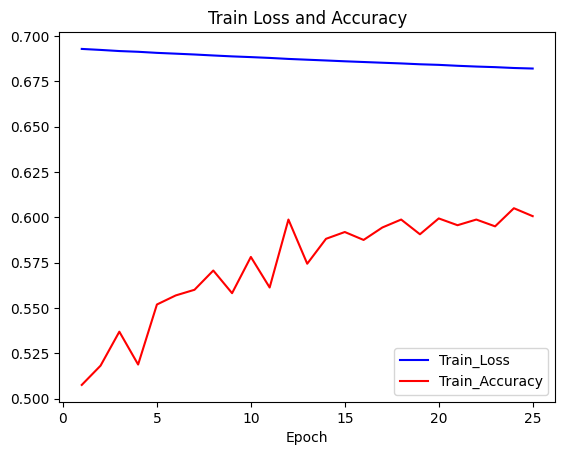

Valid Loss: 0.6854 Accuracy: 60.0000%


In [8]:
plt.figure()
plt.title('Train Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('')
plt.plot(range(1, epochs+1), np.array(train_loss_list), color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epochs+1), np.array(train_acc_list), color='red',
         linestyle='-', label='Train_Accuracy')
plt.legend()  # 凡例
plt.show()  # 表示

v_loss,  v_corr = 0.0, 0.0      
model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        preds = model(inputs)
        v_loss += loss.item() * inputs.size(0)
        v_corr += torch.sum(preds.argmax(1) == labels)
        
    print('Valid Loss: {:.4f} Accuracy: {:.4f}%'.format(v_loss / len(valid_loader.dataset),
                                                       (v_corr / len(valid_loader.dataset)) * 100))

In [9]:
test_path = './kaggle/inputs/test'
# get dataset
test_data = get_dataset(test_path, transform=transforms)
# print(len(test_data))
test_loader = DataLoader(test_data, batch_size=32)
_loss, _corr = 0.0, 0.0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y = model(inputs)
        preds = y.argmax(1)
        _loss += loss.item() * inputs.size(0)
        _corr += torch.sum(preds== labels)

    print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(_loss / len(test_loader.dataset),
                                                       (_corr / len(test_loader.dataset)) * 100))

Test Loss: 0.6854 Accuracy: 60.2500%
